In [1]:

## modify these parameters
fname_black = '/media/ericdill/data/3_9eq_03_02_2022_-25_005.mp4'

## modify these parameters
fname = 'data/3_9eq_03_02_2022_-25_005.mp4'
# fname = 'data/3_6ish_-10_11122034.mp4'
# fname = 'data/3_3_08-10-2021_-50_012.mp4'
# set to -1 to store one image per minute
store_every = -1
store_every = 5

# set to -1 to read all of the images
max_images_to_read = -1
max_images_to_read = 10000

In [2]:
## don't modify below here, just execute

In [3]:
!pwd

/home/ericdill/dev/jdm/crystal-video


In [4]:
import pathlib
fname = pathlib.Path(fname)
if not fname.exists():
    raise RuntimeError(f"Cannot find {fname}")

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import textwrap
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import traitlets

import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
from ipywidgets import interactive
import datetime

In [6]:
%matplotlib widget

In [7]:
class VideoData(traitlets.HasTraits):
    filename = traitlets.Any()
    # Store every how many frames?
    store_every = traitlets.Integer(default_value=-1)
    # How many images should we ready into memory?
    max_images_to_read = traitlets.Integer(default_value=-1)
    
    # parameters automatically managed by the class, don't set
    _vid = traitlets.Any()
    # _data = traitlets.Any()
    _fps = traitlets.Float()
    _frame_count = traitlets.Integer()
    _duration = traitlets.Float()
    _width = traitlets.Integer()
    _height = traitlets.Integer()
    _images_to_store = traitlets.Integer()
    _time_between_stored_images = traitlets.Float()
    
    def __init__(self):
        # write up interactivity
        self.observe(self._new_params)
        self._data = None
    
    def _parse_vid_metadata(self):
        if self._vid is None:
            return
        self._fps = self._vid.get(cv2.CAP_PROP_FPS)
        self._frame_count = int(self._vid.get(cv2.CAP_PROP_FRAME_COUNT))
        self._duration = self._frame_count/self._fps
        self._width = int(self._vid.get(cv2.CAP_PROP_FRAME_WIDTH))
        self._height = int(self._vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        if self.store_every == -1:
            self.store_every = int(np.ceil(self._fps))
        if self.max_images_to_read == -1:
            self.max_images_to_read = self._frame_count
        
        self._images_to_store = self.max_images_to_read // self.store_every
        self._time_between_stored_images = self.store_every / self._fps
    
    def md(self):
        all_traits = self.traits()
        del all_traits['_vid']
        d = {k: getattr(self, k) for k, v in all_traits.items()}
        return d
    
    def _init_data(self):
        self._data = np.zeros((self._images_to_store+1, self._height, self._width), dtype=np.uint8)
    
    def _open(self):
        self._vid = cv2.VideoCapture(str(self.filename))
        
    def _new_params(self, update):
        print(update)
        if update['name'] == 'filename':
            self._open()
        if update['name'] in ('_vid', 'store_every', 'max_images_to_read'):
            # parse the video metadata
            self._parse_vid_metadata()
            # self._init_data()
            
    def total_time(self):
        seconds=int(self._frame_count / self._fps)
        total_time = str(datetime.timedelta(seconds=seconds))
        return seconds, f"Movie duration: {total_time} (HH:MM:SS)"

    def index_metadata(self, idx):
        seconds = idx * self.store_every / self._fps
        dt = str(datetime.timedelta(seconds=seconds))
        index = idx * self.store_every
        return {'image_timestamp': dt, 'actual_image_index': index}

    def read(self, callback=None, store_data=True):
        """Read in video frames up to `self.max_images_to_read` but only save every `self.store_every` in memory"""
        # reset back to start of video
        self._open()
        # print out a message to the user letting them know what's about to happen
        message = f"Reading in {self.max_images_to_read} frames and "
        if store_data:
            message += (f'storing one frame every {self.store_every} frames. '
                        f"This corresponds to one frame every {self._time_between_stored_images} second(s) "
                        f"and {self._images_to_store} images will be stored in total.")
        else:
            message += 'not storing any frames because store_data=False. '
        print(message)
        for idx in trange(self.max_images_to_read-1):
            # read in an image
            ret, frame = self._vid.read()
            if not ret:
                # no more frames to read
                break
            # convert it to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if callback:
                # this callback is used to inject some analytics into the middle of the read
                # without having to write new code to do so
                callback(gray, idx)
            if idx % self.store_every == 0 and store_data:
                # store the data if the user has asked us to do so
                if self._data is None:
                    self._init_data()
                self._data[idx // self.store_every] = gray
            
        

In [8]:
v = VideoData()
v.store_every = 25
# v.max_images_to_read = 10000
v.filename = fname
v.index_metadata(1), v.index_metadata(10)

{'name': 'store_every', 'old': -1, 'new': 25, 'owner': <__main__.VideoData object at 0x7f558c1fb220>, 'type': 'change'}
{'name': 'filename', 'old': None, 'new': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'owner': <__main__.VideoData object at 0x7f558c1fb220>, 'type': 'change'}
{'name': '_vid', 'old': None, 'new': < cv2.VideoCapture 0x7f558c362210>, 'owner': <__main__.VideoData object at 0x7f558c1fb220>, 'type': 'change'}
{'name': '_fps', 'old': 0.0, 'new': 13.12227601566946, 'owner': <__main__.VideoData object at 0x7f558c1fb220>, 'type': 'change'}
{'name': '_frame_count', 'old': 0, 'new': 24780, 'owner': <__main__.VideoData object at 0x7f558c1fb220>, 'type': 'change'}
{'name': '_duration', 'old': 0.0, 'new': 1888.3919199999998, 'owner': <__main__.VideoData object at 0x7f558c1fb220>, 'type': 'change'}
{'name': '_width', 'old': 0, 'new': 1920, 'owner': <__main__.VideoData object at 0x7f558c1fb220>, 'type': 'change'}
{'name': '_height', 'old': 0, 'new': 1200, 'owner': <__main__.Video

({'image_timestamp': '0:00:01.905157', 'actual_image_index': 25},
 {'image_timestamp': '0:00:19.051573', 'actual_image_index': 250})

In [9]:
v.read()

{'name': '_vid', 'old': < cv2.VideoCapture 0x7f558c362210>, 'new': < cv2.VideoCapture 0x7f558c361a70>, 'owner': <__main__.VideoData object at 0x7f558c1fb220>, 'type': 'change'}
Reading in 24780 frames and storing one frame every 25 frames. This corresponds to one frame every 1.905157304277643 second(s) and 991 images will be stored in total.


  0%|          | 0/24779 [00:00<?, ?it/s]

In [10]:
v.md()

{'_duration': 1888.3919199999998,
 '_fps': 13.12227601566946,
 '_frame_count': 24780,
 '_height': 1200,
 '_images_to_store': 991,
 '_time_between_stored_images': 1.905157304277643,
 '_width': 1920,
 'filename': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'),
 'max_images_to_read': 24780,
 'store_every': 25}

Text(0, 0.5, 'total image intensity')

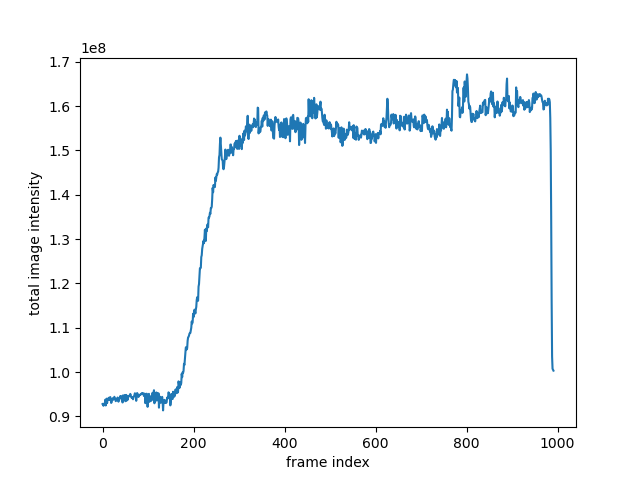

In [11]:
## Plot summed intensity over time
I = np.sum(v._data, axis=(1,2))
fig, ax = plt.subplots()
lines = ax.plot(I)
ax.set_xlabel("frame index")
ax.set_ylabel("total image intensity")

In [12]:
def imshow_with_patches(ax, data, patches: dict):
    try:
        im = ax.images[-1]
    except IndexError:
        print("No image currently show. calling ax.imshow")
        im = ax.imshow(data)
    else:
        im.set_data(data)
    
    print(f"Removing {len(ax.patches)} existing patches")
    
    for existing_patch in ax.patches:
        existing_patch.remove()
    added_patches = {}
    for patch_name, patch in patches.items():
        print(f"Adding patch for {patch_name}")
        added_patches[patch_name] = ax.add_patch(patch)
    return im, added_patches
    
class VideoScrubber(traitlets.HasTraits):
    video_data = traitlets.Any()
    
    def __init__(self):
        self.slider = widgets.IntSlider()
        self.timestamp = widgets.Text(description="HH:MM:SS")
        self.actual_frame = widgets.Text(description="actual frame")
        self.plot = widgets.Output()
        self.threshold = widgets.Text(description="intensity threshold", value="0")
        # Init the matplotlib plot
        self.fig, self.ax = plt.subplots()
        self.patches = {}
        
        # Define the layout
        with self.plot:
            plt.show(self.fig)

        # interactive_plot = interactive(self._plotter, idx=self.slider)
        # interact(self._plotter, frame_idx=self.slider)
        
        self.layout = widgets.VBox([
            self.slider,
            self.threshold,
            self.plot,
            self.timestamp, 
            self.actual_frame,
        ])
        
        # display(self.layout)
        
        # wire up interactivity
        
        self.observe(self._updater_callback)
        self.threshold.observe(self._updater_callback, names=['value'])
        self.slider.observe(self._plotter_callback, names=['value'])
        
    
    def _update_plot(self, frame_idx):
        if self.video_data is None:
            return
        print(frame_idx)
        # return
        data = self.video_data._data[frame_idx].copy().astype(int)
        background = self.video_data._data[0]
        data -= background
        threshold = int(self.threshold.value)
        data[data < threshold] = 0
        
        imshow_with_patches(self.ax, data, self.patches)
        
        # Get previous zoom
        self.fig.canvas.draw_idle()
        md = v.index_metadata(frame_idx)
        self.timestamp.value = md['image_timestamp']
        self.actual_frame.value = str(md['actual_image_index'])
        #TODO Update other text boxes
    
    def _draw_patches(self):
        patches = self.patches
        frame_idx = self.slider.value
        self._update_plot(frame_idx)
        
    def _plotter_callback(self, update):
        frame_idx = update['new']
        self._update_plot(frame_idx)
        
    def _updater_callback(self, update):
        print(update)
        if update['name'] == 'video_data':
            md = self.video_data.md()
            print(md)
            self.slider.max = len(self.video_data._data)-1
        if update['name'] == 'threshold':
            frame_idx = self.slider.value
            self._update_plot(frame_idx)
            

In [13]:
vs = VideoScrubber()
vs.video_data = v

display(vs.layout)


{'name': 'video_data', 'old': None, 'new': <__main__.VideoData object at 0x7f558c1fb220>, 'owner': <__main__.VideoScrubber object at 0x7f55849c0700>, 'type': 'change'}
{'_duration': 1888.3919199999998, '_fps': 13.12227601566946, '_frame_count': 24780, '_height': 1200, '_images_to_store': 991, '_time_between_stored_images': 1.905157304277643, '_width': 1920, 'filename': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'max_images_to_read': 24780, 'store_every': 25}


In [14]:
import ipywidgets

In [15]:
import some_math

In [16]:
import importlib
importlib.reload(some_math)
import some_math

In [17]:
v._data[0]

array([[13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       ...,
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13]], dtype=uint8)

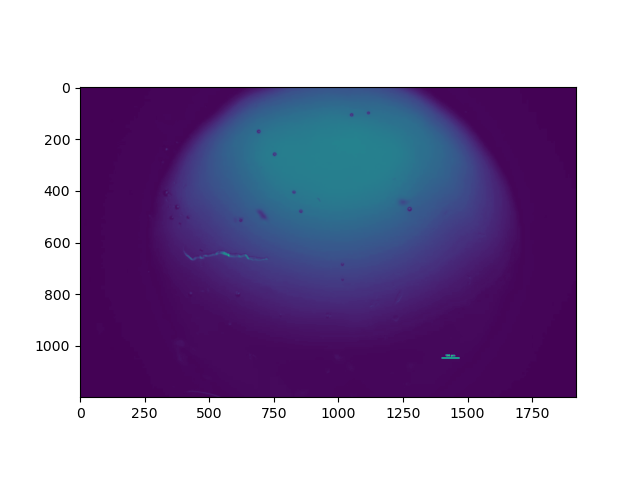

In [18]:
fig, ax = plt.subplots()

ax.imshow(v._data[0])

In [19]:
class UI(traitlets.HasTraits):
    frame_idx = traitlets.Integer()
    # video_data = traitlets.Any()
    lines = traitlets.List()
    
    def __init__(self):
        self.add_line_button = widgets.Button(description="Add Line")
        self.textbox = widgets.Text(description="HH:MM:SS")
        self.actual_frame = widgets.Text(description="actual frame")
        self.video_scrubber = VideoScrubber()
        self.plot = widgets.Output()
        self.slider = widgets.IntSlider()
        self.line_patches = {}
        
        # Wire up interactivity
        self.add_line_button.on_click(self._on_click)
        # self.observe(self._new_data, names=['video_data'])
        
        # Do the displaying stuff
        self.line_layout = widgets.VBox([self.add_line_button])
        with self.plot:
            plt.show(self.fig)
            
        self.layout = widgets.HBox([
            self.video_scrubber.layout,
            self.line_layout,
        ])
        display(self.layout)
        
    def _on_click(self, b):
        print(b)
        lf = some_math.LinearFace()
        lf.callback=self._update_line_data_callback
        self.lines.append(lf)
        self.line_layout.children = [_.layout for _ in self.lines] + [self.add_line_button]
        
    # def _new_data(self, data):
    #     print(data)
    #     print(self.video_data)
    #     self.ax.imshow(self.video_data._data[0])
    #     self.fig.canvas.draw()
        
    def _update_line_data_callback(self, obj):
        print(f'received update for {obj.name}')
        x0,y0 = obj.p1.x, obj.p1.y
        width = float(obj.width.value)
        height = float(obj.height.value)
        color = obj.color_picker.value
        th_deg = obj.rect_angle
        print(f'rectangle info: x0={x0},y0={y0},width={width},height={height},th_deg={th_deg},color={color}')
        patch = some_math.mpl_rect_patch(
            x=x0, y=y0, width=width, height=height, color=color,
            axes=self.video_scrubber.ax, rot=th_deg
        )
        self.line_patches[obj.name.value] = patch
        self.video_scrubber.patches = self.line_patches
        self.video_scrubber._draw_patches()
        
        
        

ui = UI()
ui.video_scrubber.video_data = v

{'name': 'video_data', 'old': None, 'new': <__main__.VideoData object at 0x7f558c1fb220>, 'owner': <__main__.VideoScrubber object at 0x7f551e74a7d0>, 'type': 'change'}
{'_duration': 1888.3919199999998, '_fps': 13.12227601566946, '_frame_count': 24780, '_height': 1200, '_images_to_store': 991, '_time_between_stored_images': 1.905157304277643, '_width': 1920, 'filename': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'max_images_to_read': 24780, 'store_every': 25}


# STOP HERE and interact with the above figure to decide which box you want to extract data for

In [21]:
image = v._data[444]
patch = next(iter(ui.video_scrubber.patches.values()))
mask = some_math.make_image_mask(image, patch)
x,y,i = some_math.extract_pixels_xyi(image, patch)

In [22]:
patch

In [23]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [24]:
x,y,i

(array([794, 795, 796, ..., 461, 459, 460]),
 array([  0,   0,   0, ..., 537, 538, 538]),
 array([109, 109, 110, ...,  52,  52,  53], dtype=uint8))

In [25]:
l = i.shape[0]

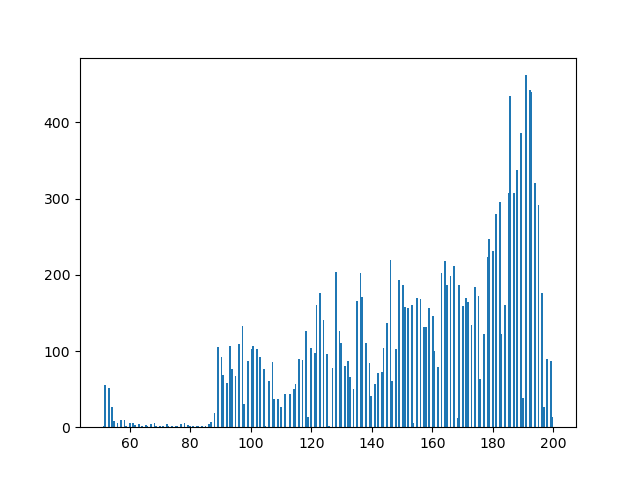

In [26]:
fig,ax = plt.subplots()
ax.hist(i, bins=256);

In [27]:
class Outputter:
    def __init__(self, num_frames, patch, name : str, threshold: int = None, background: np.array = None):
        self.patch = patch
        self.num_frames = num_frames
        self.name = name
        # will be set on init_output
        self.mask = None     
        self.output_data = None
        self.num_pixels = None
        self.threshold = threshold
        self.background = background
        self.crystallized = None
    
    def init_output(self, image):
        self.mask = some_math.make_image_mask(image, self.patch)
        self.num_pixels = len(self.mask[self.mask])
        self.output_data = np.zeros(shape=(self.num_frames, self.num_pixels))
        
    def reader_callback(self, image, image_idx):
        # print('in callback')
        # we dont want to edit the original image
        image2 = image.copy().astype(int)
        if self.background is not None:
            # subtract the background if we have it
            image2 -= background
        if self.threshold is not None:
            # set everything below the threshold to 0
            image2[image2 < threshold] = 0
        if self.mask is None:
            self.init_output(image2)
            self.x, self.y, _ = some_math.extract_pixels_xyi(image2, self.patch)
        
        I = image2[self.mask]
        self.output_data[image_idx] = I
        
            
            

In [28]:
num_frames = v._frame_count
background = v._data[0]
threshold = int(ui.video_scrubber.threshold.value)
o = [
    Outputter(num_frames, patch, name=patch_name, background=background,
             threshold=threshold) 
    for patch_name, patch in sorted(ui.video_scrubber.patches.items())]

In [29]:
def reader_callback(image, image_idx, outputters=None):
    for outputter in outputters:
        outputter.reader_callback(image, image_idx)

In [30]:
import functools

In [31]:
v2 = VideoData()
# v.store_every = 100
# v.max_images_to_read = 10000
v2.filename = fname
v2.read(callback=functools.partial(reader_callback, outputters=o), store_data=False)


{'name': 'filename', 'old': None, 'new': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'owner': <__main__.VideoData object at 0x7f551c4ae0b0>, 'type': 'change'}
{'name': '_vid', 'old': None, 'new': < cv2.VideoCapture 0x7f551c46a110>, 'owner': <__main__.VideoData object at 0x7f551c4ae0b0>, 'type': 'change'}
{'name': '_fps', 'old': 0.0, 'new': 13.12227601566946, 'owner': <__main__.VideoData object at 0x7f551c4ae0b0>, 'type': 'change'}
{'name': '_frame_count', 'old': 0, 'new': 24780, 'owner': <__main__.VideoData object at 0x7f551c4ae0b0>, 'type': 'change'}
{'name': '_duration', 'old': 0.0, 'new': 1888.3919199999998, 'owner': <__main__.VideoData object at 0x7f551c4ae0b0>, 'type': 'change'}
{'name': '_width', 'old': 0, 'new': 1920, 'owner': <__main__.VideoData object at 0x7f551c4ae0b0>, 'type': 'change'}
{'name': '_height', 'old': 0, 'new': 1200, 'owner': <__main__.VideoData object at 0x7f551c4ae0b0>, 'type': 'change'}
{'name': 'store_every', 'old': -1, 'new': 14, 'owner': <__main__.Video

  0%|          | 0/24779 [00:00<?, ?it/s]

In [32]:
outputter = o[0]
data = outputter.output_data
data

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [15., 15., 14., ...,  4.,  4.,  4.],
       [15., 15., 14., ...,  4.,  4.,  4.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Thresholding with static value

In [33]:
from skimage.filters import threshold_otsu

In [34]:
a = np.zeros_like(np.zeros(shape=(5,5)), dtype=bool)
a

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [35]:
a[:] = True

In [36]:
a

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [37]:
def get_transformed_orig(data, th=None, otsu=False):
    crystallized = []
    for i in range(len(data)):
        pixels = data[i]
        if otsu:
            th = threshold_otsu(pixels)
        pixels2 = pixels.copy()
        pixels2[pixels2 < th] = 0
        crystallized_pixels = len(pixels2[pixels2 != 0])
        crystallized.append(crystallized_pixels / len(pixels))
    return crystallized

In [38]:
from collections import namedtuple

In [39]:
Thresholded = namedtuple('threhsolded', 'per_frame cumsum final_mask')
def get_transformed(data, th=None, otsu=False):
    crystallized_per_frame = []
    crystallized_boolean = np.zeros_like(data[0], dtype=bool)
    crystallized_boolean[:] = False
    for i in range(len(data)):
        pixels = data[i]
        pixels2 = pixels.copy()
        pixels2[crystallized_boolean] = 0
        if otsu:
            th = threshold_otsu(pixels2)
        pixels2[pixels2 < th] = 0
        crystallized_boolean |= pixels2 > 0
        crystallized_pixels = len(pixels2[pixels2 != 0])
        crystallized_per_frame.append(crystallized_pixels / len(pixels))
    return Thresholded(crystallized_per_frame, np.cumsum(crystallized_per_frame), crystallized_boolean)

In [40]:
def plot_threshold(thresh: dict, reference_threshold_value: float, 
                   axes_data, axes_diff):
    ref = thresh[reference_threshold_value].cumsum
    for threshold_val, th in reversed(thresh.items()):
        cumsum = th.cumsum
        axes_data.plot(cumsum, label=f'threshold={threshold_val}')
        if reference_threshold_value == threshold_val:
            continue
        diff = ref - cumsum
        axes_diff.plot(diff, label=f'{reference_threshold_value} minus {threshold_val}')
        
    axes_data.legend()
    axes_diff.legend()
    axes_diff.set_xlabel('frame number')
    axes_diff.set_ylabel('normalized intensity (0..1)')
    axes_data.set_ylabel('normalized intensity (0..1)')

# STOP HERE AND INTERACT

In [41]:
# Any sort of iterable works here. lists, ranges, etc.
threshold_values = range(7,12)
# threshold_values = [5, 8, 10, 15]
thresholding_dict = {}
for val in threshold_values:
    print(f'thresholding:{val}')
    thresholding_dict[val] = get_transformed(data, th=val)
    

thresholding:7
thresholding:8
thresholding:9
thresholding:10
thresholding:11


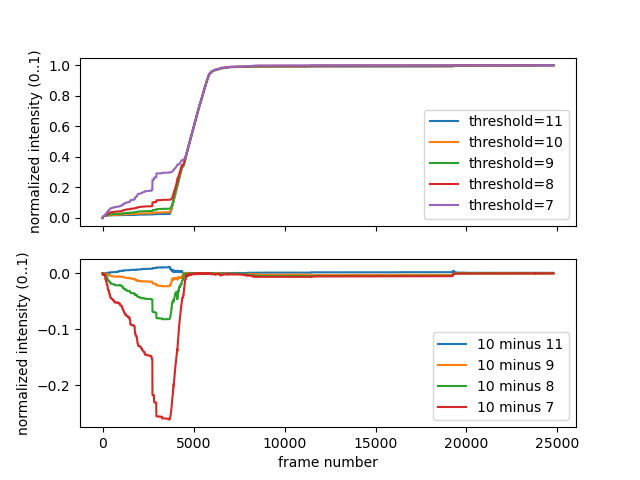

In [42]:
# set this
reference_threshold_value = 10
# set that -------------->  ^^^

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
plot_threshold(thresholding_dict, reference_threshold_value=reference_threshold_value,
               axes_data=ax1, axes_diff=ax2)

In [43]:
# After evaluating the above, decide which threshold you want:
# You change the value for this variable
desired_threshold = 10
# change this -->   ^^^


# In the above cell, decide what threshold value you want
Then keep running the cells below

## Interactively evaluate threshold values if you want

interactive(children=(IntSlider(value=0, continuous_update=False, description='frame_idx', max=24780), Output(…

<function __main__.plotter(frame_idx)>

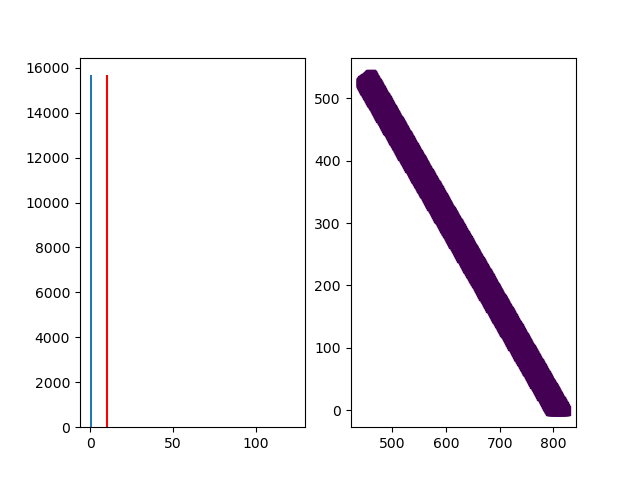

In [44]:
data = outputter.output_data
slider = widgets.IntSlider(max=len(data), continuous_update=False)
fig, (ax1,ax2) = plt.subplots(ncols=2)
bins = np.arange(0, 125, 1)
def plotter(frame_idx):
    print(frame_idx)
    frame_idx = int(frame_idx)
    pixels = data[frame_idx]
    ax1.clear()
    vals, _, _ = ax1.hist(pixels, bins)
    # thresh = threshold_otsu(pixels)
    ax1.vlines(thresh, 0, max(vals), color='red')
    pixels2 = pixels.copy()
    pixels2[pixels2 < thresh] = 0
    ax2.scatter(x,y, c=pixels2, marker='s')
    fig.canvas.draw_idle()
    
thresh = 10
interact(plotter, frame_idx=slider)

# Use the above plot to pick out the two points that make up the long axis of the image

### Then put those two points in the cell below under "p1" and "p2". It doesn't matter which is which as they're only used to compute the distance

TODO: Consider automatically trying to find the tight bounding polygon that would allow us to extract the vertices more easily.
- or could just try to find the following 8 points:
    - for min/max x, find min/max y (so 4 points total)
    - for min/max y, find min/max x (so another 4 points)
    - then make another widget right of the above plot with those 8 points listed out
    - and plot those 8 points on the image plot above
    - and link those points between whats shown on the plot and the widget to the right somehow (color, shape, label, etc.) 
    

In [45]:
from scipy import spatial

p1 = (456,534)
p2 = (809,0)
distance_px = spatial.distance.euclidean(p1,p2)
distance_um = distance_px / 68 * 100
distance_um

941.3660195157682

- multiply y axis by distance_um and in theory then you 
- convert x axis to time and then fit the curve with something

In [46]:
crystallized_cumsum = thresholding_dict[desired_threshold].cumsum
y_um = crystallized_cumsum * distance_um
x_t = np.arange(len(crystallized_cumsum)) / v2._fps

Text(0.5, 0, 'time (s)')

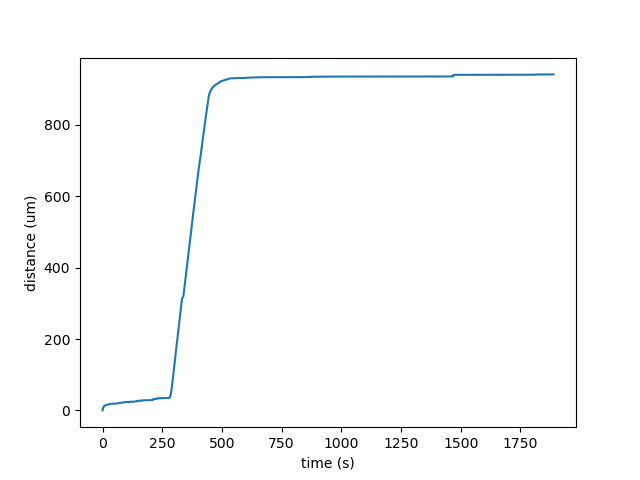

In [47]:
fig, ax = plt.subplots()
ax.plot(x_t,y_um, label=10)
ax.set_ylabel('distance (um)')
ax.set_xlabel('time (s)')


In [48]:
len(x_t), len(y_um)

(24780, 24780)

In [49]:
out = np.zeros(shape=(2,len(x_t)))
out[0] = x_t
out[1] = y_um

In [59]:
csv_name = fname.parent.absolute() / (fname.name + '.csv')

In [60]:
np.savetxt(f'{csv_name}.csv', out.T, delimiter=',')

# Output file written to:

In [62]:
str(csv_name)

'/home/ericdill/dev/jdm/crystal-video/data/3_9eq_03_02_2022_-25_005.mp4.csv'